In [1]:
import sys
sys.path.append('../src/')
import numpy as np
import scipy
import torch
np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [2]:
%load_ext autoreload
%autoreload 2

import priors

In [3]:
def my_truncnorm(a, b, mu, sig):
    aa = (a - mu) / sig
    bb = (b - mu) / sig
    return scipy.stats.truncnorm(aa, bb, mu, sig)

In [4]:
tau_prior = my_truncnorm(0.0, np.inf, 0.01, 0.01)
tau_samples = tau_prior.rvs(10000000)
print(np.percentile(tau_samples, [0, 5, 20, 50, 80, 95, 99, 100]))

[0.0000 0.0016 0.0055 0.0120 0.0196 0.0273 0.0339 0.0643]


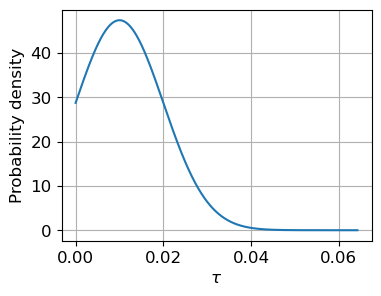

In [5]:
x = np.linspace(0, np.max(tau_samples), 1000)
pdf_values = tau_prior.pdf(x)
plt.figure(figsize=(4, 3))
# Plot the PDF
plt.plot(x, pdf_values, color='#1f77b4')
plt.xlabel(r'$\tau$')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

In [6]:
def calc_outputscale_prior(tau_prior, desired_low, desired_high, num_samples=1000):
    desired_medium = (desired_high+desired_low)/2
    best_dist = np.inf
    best_m, best_s = 0, 0
    tau_samples = tau_prior.rvs(num_samples)
    for m in np.linspace(0.001, 0.05, 100):
        for s in np.linspace(0.001, 0.05, 100):
            outputscale_prior = my_truncnorm(0.0, np.inf, m, s)
            outputscale_samples = outputscale_prior.rvs(num_samples)
            expression_values = 6*np.sqrt(outputscale_samples**2+tau_samples**2)
            low, medium, high = np.percentile(expression_values, [20, 50, 80])
            if abs(desired_low - low) + abs(desired_medium - medium) + abs(desired_high - high) < best_dist:
                best_dist = abs(desired_low - low) + abs(desired_medium - medium) + abs(desired_high - high)
                best_m, best_s = m, s
    outputscale_prior = my_truncnorm(0.0, np.inf, best_m, best_s)
    outputscale_samples = outputscale_prior.rvs(num_samples)
    expression_values = 6*np.sqrt(outputscale_samples**2+tau_samples**2)
    return best_m, best_s

In [7]:
epsilon = 0.05
y_n = 0.7
desired_low = (1/2)*((1-epsilon)-y_n)
desired_high = (3/4)*((1-epsilon)-y_n)
print('Desired low: {}'.format(desired_low))
print('Desired medium: {}'.format((desired_high+desired_low)/2))
print('Desired high: {}'.format(desired_high))

Desired low: 0.125
Desired medium: 0.15625
Desired high: 0.1875


In [8]:
m, s = calc_outputscale_prior(tau_prior, desired_low, desired_high)
outputscale_prior = my_truncnorm(0.0, np.inf, m, s)
outputscale_samples = outputscale_prior.rvs(10000000)
print(np.percentile(outputscale_samples, [0, 5, 20, 50, 80, 95, 100]))

[0.0000 0.0136 0.0176 0.0218 0.0260 0.0299 0.0470]


In [9]:
print(m)
print(s)

0.02178787878787879
0.00495959595959596


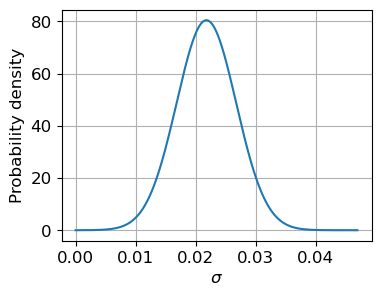

In [10]:
x = np.linspace(0, np.max(outputscale_samples), 1000)
pdf_values = outputscale_prior.pdf(x)
plt.figure(figsize=(4, 3))
# Plot the PDF
plt.plot(x, pdf_values, color='#1f77b4')
plt.xlabel(r'$\sigma$')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

In [11]:
expression_values = 6*np.sqrt(outputscale_samples**2+tau_samples**2)
print(np.percentile(expression_values, [0, 5, 20, 50, 80, 95, 100]))

[0.0018 0.1009 0.1271 0.1560 0.1873 0.2207 0.4222]


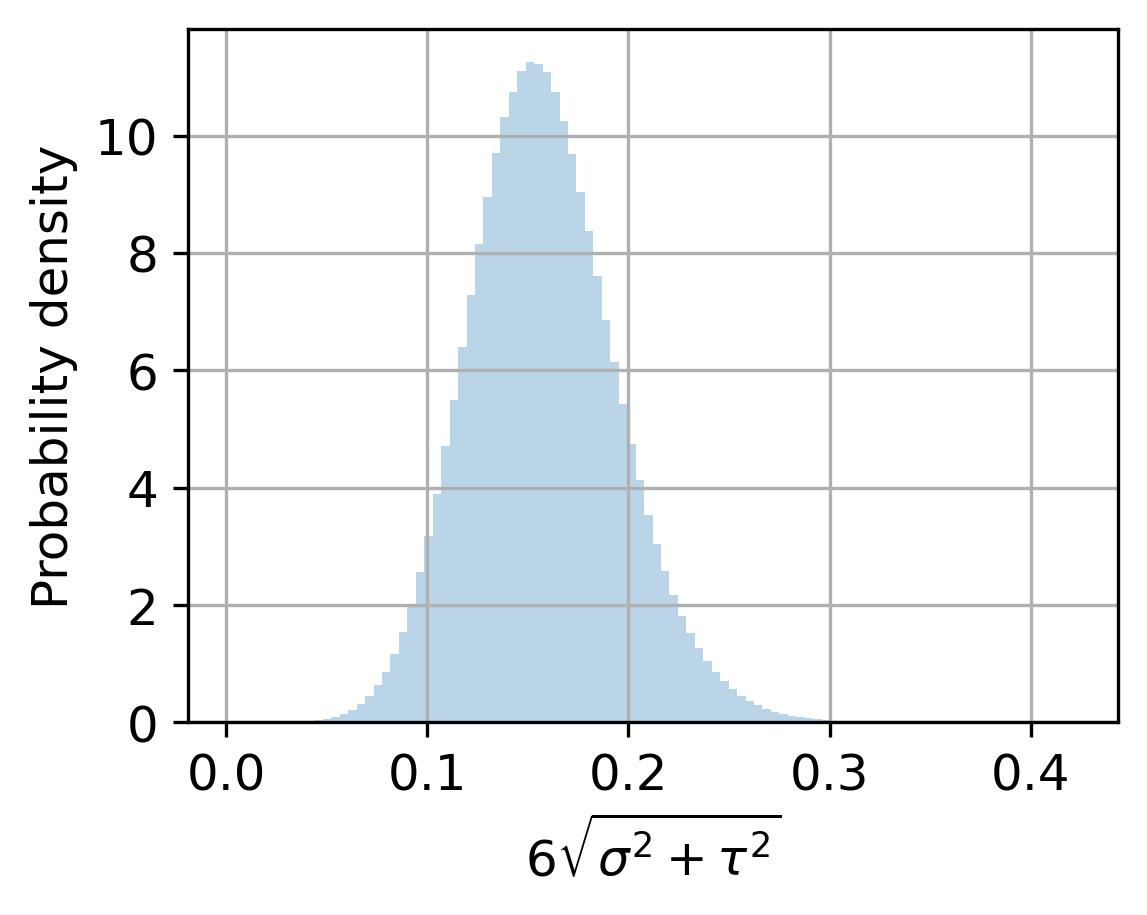

In [12]:
plt.figure(figsize=(4, 3), dpi=300)
plt.hist(expression_values, bins=100, density=True, alpha=0.3, color='#1f77b4')
plt.xlabel(r'$6\sqrt{\sigma^2+\tau^2}$')
plt.ylabel("Probability density")
plt.grid(True)
plt.show()

In [13]:
lengthscale_prior = my_truncnorm(0.0, np.inf, -1.23, 2.12)
lengthscale_samples = lengthscale_prior.rvs(10000000)
print(np.percentile(lengthscale_samples, [0, 5, 20, 50, 80, 95, 100]))

[0.0000 0.0896 0.3738 1.0568 2.1362 3.4247 11.1717]


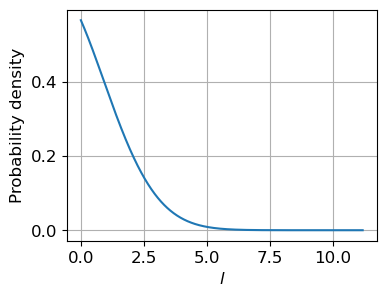

In [14]:
x = np.linspace(0, np.max(lengthscale_samples), 1000)
pdf_values = lengthscale_prior.pdf(x)
plt.figure(figsize=(4, 3))
# Plot the PDF
plt.plot(x, pdf_values, color='#1f77b4')
plt.xlabel(r'$l$')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()

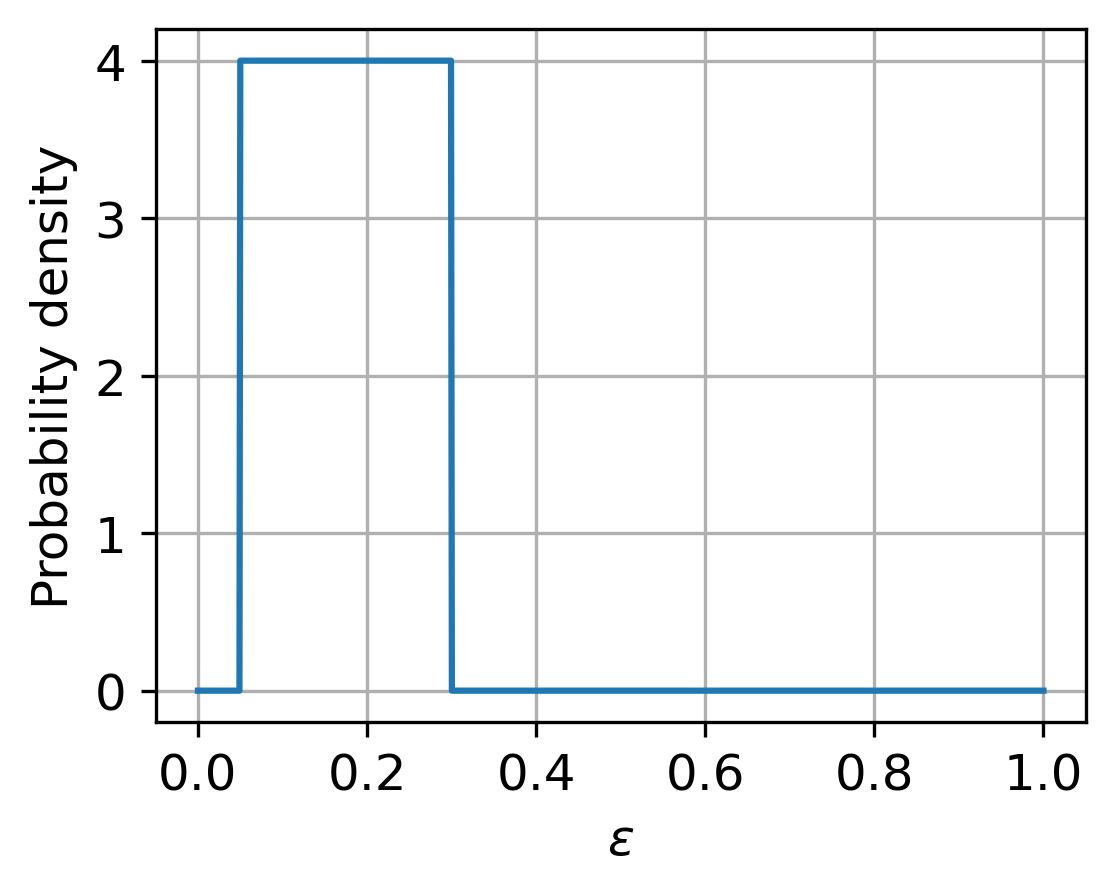

In [15]:
epsilon_min = 0.05
y_max = 0.7
epsilon_prior = priors.TruncatedNormalPrior(epsilon_min, 1.0-y_max, epsilon_min+(1/2)*(1.0-y_max-epsilon_min), (1/2)*(1.0-y_max-epsilon_min))
epsilon_prior = priors.EpsilonPrior(1.0-y_max, epsilon_min)
epsilon_prior = priors.UniformPrior(epsilon_min, 1.0-y_max)
x = torch.linspace(0, 1, 1000)
pdf_values = [epsilon_prior(i) for i in x]
plt.figure(figsize=(4, 3), dpi=300)
# Plot the PDF
plt.plot(x, pdf_values, color='#1f77b4')
plt.xlabel(r'$\varepsilon$')
plt.ylabel('Probability density')
plt.grid(True)
plt.show()